In [5]:
"""
TILE EXTRACTION

Andrea Perera-Ortega

This code will be used to generate the concatenated tiles used in order to train the model. This code has been modified from iafoss in the MICCAI PANDA Challenge on Kaggle. This method was used by most of the competitors as it is time and space efficient and we don't have to worry about labelling individual patches. We're then going to take 16 individual patches
of size 64x64. The final resulting image of concatenated tiles will be of size 256x256 at 8x downsampled resolution. Export all images as numpy array.
"""

import os
import sys
from skimage import io
import numpy as np
import glob
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import math
from skimage.measure import block_reduce

In [2]:
# location of training images and masks
BASE_PATH = '/home/andrea/miccai2020/miccai-data/' # miccai-data is 
train_dir = '/home/andrea/miccai2020/miccai-data/train_images'
mask_dir = BASE_PATH + 'train_label_masks'
label_path = BASE_PATH + 'train.csv'

sz = 64 # size of individual tile
N = 16 # number of tiles

In [3]:
# make tile directory
tiles_dir = '/home/andrea/miccai2020/CISC881/tiles'
tiles_16x64x64 = os.path.join(tiles_dir, "tiles_16x64x64/")

if not os.path.exists(tiles_16x64x64):
    os.makedirs(tiles_16x64x64)
    print("created tiles_16x64x64 directory.")
else:
    print("tiles_16x64x64 directory exists.")

tiles_16x64x64 directory exists.


In [6]:
# remove suspicious cases
suspicious_cases = '/home/andrea/miccai2020/miccai-data/suspicious_test_cases.csv'
suspicious_cases_df = pd.read_csv(suspicious_cases)

label_df = pd.read_csv(label_path)
print("Number of images before omitting suspicious cases: ", label_df.shape[0])
# reasons we should omit these cases 
suspicious_cases_df['Suspicious_because'].value_counts()

suspicious_case_list = suspicious_cases_df['image_id'].tolist()
label_df = label_df[~label_df['image_id'].isin(suspicious_case_list)]

print("Number of suspicious cases to be removed: ", len(suspicious_case_list))
print("Number of images after omitting suspicious cases: ", label_df.shape[0])

Number of images before omitting suspicious cases:  10616
Number of suspicious cases to be removed:  189
Number of images after omitting suspicious cases:  10427


In [7]:
# get the min and max axes values for tile extraction
def get_axis_max_min_vals(array, axis=0):
    one_axis = list((array != 255).sum(axis=tuple([x for x in (0, 1, 2) if x != axis])))
    axis_min = next((i for i, x in enumerate(one_axis) if x), 0)
    axis_max = len(one_axis) - next((i for i, x in enumerate(one_axis[::-1]) if x), 0)
    return axis_min, axis_max

# get the individual patches
def get_tiles(img_path, seq_len=16, img_size=64):
    num_patches = seq_len
    p_size = img_size
    img = io.MultiImage(img_path)[1] # take the mid level resolution (4x downsample)

    # downsample image by another factor of 2x to equal 8x downsampling
    img = block_reduce(img, block_size=(2,2,1), func=np.min) # get the minimum value in the block to use

    a0min, a0max = get_axis_max_min_vals(img, axis=0)
    a1min, a1max = get_axis_max_min_vals(img, axis=1)

    # normalize image intensitities from 0-1
    img = img[a0min:a0max, a1min:a1max, :].astype(np.float32) / 255
    # pad image
    pad0, pad1 = (p_size - img.shape[0] % p_size) % p_size, (p_size - img.shape[1] % p_size) % p_size
    img = np.pad(
        img,
        [
            [pad0 // 2, pad0 - pad0 // 2], 
            [pad1 // 2, pad1 - pad1 // 2], 
            [0, 0]
        ],
        constant_values=1
    )
    # reshape with the appropriate padding
    img = img.reshape(img.shape[0] // p_size, p_size, img.shape[1] // p_size, p_size, 3)
    img = img.transpose(0, 2, 1, 3, 4).reshape(-1, p_size, p_size, 3)
    if len(img) < num_patches:
        img = np.pad(
            img, 
            [
                [0, num_patches - len(img)],
                [0, 0],
                [0, 0],
                [0, 0]
            ],
            constant_values=1
        )
    idxs = np.argsort(img.reshape(img.shape[0], -1).sum(-1))[:num_patches]
    return np.array(img[idxs])

"""
This function will glue all of the individual tiles together into one image of concatenated tiles.
An example is shown below
"""
def glue_to_one(tiles, tile_size=64, num_tile=16):
    l_tile = int(math.sqrt(num_tile))
    img_glue = np.zeros((l_tile*tile_size, l_tile*tile_size, 3),
                         dtype = np.float32)
    for i, t in enumerate(tiles): # put the tiles together
        x = i//l_tile
        y = i%l_tile
        img_glue[x*tile_size:(x+1)*tile_size,
                 y*tile_size:(y+1)*tile_size, :] = t
    return img_glue

#### Convert all biopsies into concatenated tile images

In [9]:
train_dir = '/home/andrea/miccai2020/miccai-data/train_images'

tiles_list = []

# subset_df = label_df.head(3)

for index, row in label_df.iterrows(): 
    print(index)
    image = os.path.join(train_dir, row['image_id'] + '.tiff') 
    print(image)
    tiles = get_tiles(image)
    tiles_glued = glue_to_one(tiles)
    # can uncomment below for debug/tracking progress purposes
    # print(tiles_glued.shape)
    # img_name = row['image_id'] + '_tiles.tiff'
    # print(img_name)
    tiles_list.append(tiles_glued)

# convert list into numpy array
tiles_arr = np.asarray(tiles_list)
print(tiles_arr.shape)

# save as np array with shape 10427x256x256x3
output_dir = os.path.join(tiles_16x64x64, "256x256_8x_tiles")
# np.save(output_dir, tiles_arr)

0
/home/andrea/miccai2020/miccai-data/train_images/0005f7aaab2800f6170c399693a96917.tiff
1
/home/andrea/miccai2020/miccai-data/train_images/000920ad0b612851f8e01bcc880d9b3d.tiff
2
/home/andrea/miccai2020/miccai-data/train_images/0018ae58b01bdadc8e347995b69f99aa.tiff
(3, 256, 256, 3)


#### Example of a biopsy before and after tiling

/home/andrea/miccai2020/miccai-data/train_img_subset/00a26aaa82c959624d90dfb69fcf259c.tiff
(256, 256, 3)


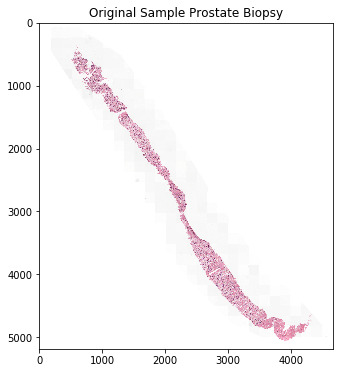

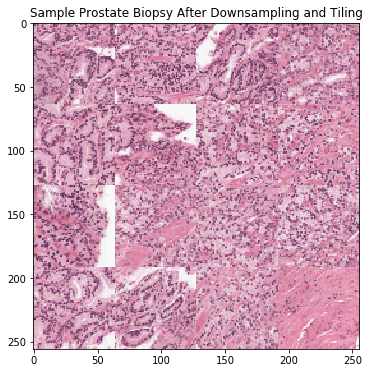

In [22]:
subset_imgs = glob.glob('/home/andrea/miccai2020/miccai-data/train_img_subset/*')
subset_imgs.sort()
test = subset_imgs[0]
print(test)
img = io.MultiImage(test)[1]
plt.figure(figsize=(6,6))
plt.title("Original Sample Prostate Biopsy")
plt.imshow(img)
plt.show

test_patches = get_tiles(test)
glue = glue_to_one(test_patches)
print(glue.shape)
plt.figure(figsize=(6,6))
plt.title("Sample Prostate Biopsy After Downsampling and Tiling")
plt.imshow(glue)